# MCMC for AF Lep b

## 1. Imports

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '5'

In [ ]:
from pathlib import Path
from tqdm import tqdm

import numpy as np

# Plotting
import cmocean
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
color_map = cmocean.cm.ice
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Methods
import pynpoint as pp
from pynpoint.core.dataio import OutputPort, InputPort
from pynpoint.readwrite.hdf5reading import Hdf5ReadingModule
from pynpoint.processing.stacksubset import StackAndSubsetModule

from s4hci.utils.pca import pca_psf_subtraction_gpu
from s4hci.utils.data_handling import save_as_fits
from s4hci.utils.data_handling import read_s4hci_root_dir

# Evaluation
from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, fpf_2_gaussian_sigma, gaussian_sigma_2_fpf

## 2. All directories needed

In [ ]:
root_dir = Path(read_s4hci_root_dir())

In [4]:
experiment_root_dir = root_dir / Path("70_results/x2_af_lep/MCMC/")

In [5]:
fwhm = 3.6

## 3. Estimate the Photometry and astrometry with PynPoint

### 3.1 Create the PynPoint database

In [6]:
pipeline = pp.Pypeline(
    working_place_in=str(experiment_root_dir),
    input_place_in=str(experiment_root_dir),
    output_place_in=str(experiment_root_dir))

PynPoint v0.10.1

A new version (0.11.0) is available!

Want to stay informed about updates, bug fixes, and new features?
Please consider using the 'Watch' button on the Github page:
https://github.com/PynPoint/PynPoint

Working place: /home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/x2_af_lep/MCMC
Input place: /home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/x2_af_lep/MCMC
Output place: /home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/x2_af_lep/MCMC

Database: /home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/x2_af_lep/MCMC/PynPoint_database.hdf5
Configuration: /home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/x2_af_lep/MCMC/PynPoint_config.ini

Number of CPUs: 32
Number of threads: 5


### 3.2 Read in the HDF5 file

In [7]:
read_data_module = Hdf5ReadingModule(
    name_in="01_read_data",
    input_filename="HD35850_294_088_C-0085_A_.hdf5",
    input_dir=str(root_dir / Path("30_data")),
    tag_dictionary={"object_selected" : "object_selected",
                    "psf_selected" : "psf_selected"})

In [8]:
pipeline.add_module(read_data_module)

In [9]:
pipeline.run_module("01_read_data")


-----------------
Hdf5ReadingModule
-----------------

Module name: 01_read_data
Reading HDF5 file... [DONE]                      
Output ports: object_selected (13809, 165, 165), psf_selected (1526, 23, 23)


### 3.3 Cut and stack the science data for faster PCA iterations

In [10]:
science_data = pipeline.get_data("object_selected")
angles = pipeline.get_attribute("object_selected", "PARANG", static=False)

print(science_data.shape)

(13809, 165, 165)
(13809,)


In [11]:
science_data_cut = science_data[:, 25:-25, 25:-25]

In [12]:
binning = 5  # stack every 5 frames
angles_stacked = np.array([
    np.mean(i) 
    for i in np.array_split(angles, int(len(angles) / binning))])
science_stacked = np.array([
    np.mean(i, axis=0) 
    for i in np.array_split(science_data_cut, int(len(angles) / binning))])

In [13]:
obj_port = OutputPort(
    "01_science_prep",
    pipeline.m_data_storage)
obj_port.set_all(science_stacked)

In [14]:
input_port = InputPort(
    "object_selected",
    pipeline.m_data_storage)
obj_port.copy_attributes(input_port)

In [15]:
pipeline.set_attribute("01_science_prep", "PARANG", angles_stacked, False)

### 3.4 Find the best number of PCA components

In [16]:
science_data_prep = pipeline.get_data("01_science_prep")
angles_prep = pipeline.get_attribute("01_science_prep", "PARANG", static=False)
angles_prep = np.deg2rad(angles_prep)

In [17]:
print(science_data_prep.shape)
print(angles_prep.shape)

(2761, 115, 115)
(2761,)


In [18]:
num_components = np.arange(5, 200, 10)

In [19]:
pca_residuals = pca_psf_subtraction_gpu(
    images=science_data_prep,
    angles=angles_prep,
    pca_numbers=num_components,
    device="cpu",
    approx_svd=2000,
    verbose = True)

Compute PCA basis ...[DONE]
Compute PCA residuals ...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s]

[DONE]


In [20]:
init_planet_position  = np.array((68.55, 54.78)) # Result from previous mcmc
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("AS", search_area=0.5, psf_fwhm_radius=fwhm/2)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=fwhm/2)

In [21]:
all_snr_pca = []
for i in tqdm(range(len(num_components))):
    _, _, snr_mean = compute_detection_uncertainty(
        frame=pca_residuals[i],
        planet_position=init_planet_position, 
        statistical_test=TTest(),
        psf_fwhm_radius=fwhm,
        photometry_mode_planet=photometry_mode_planet,
        photometry_mode_noise=photometry_mode_noise,
        safety_margin=1.,
        num_rot_iter=50)
    
    all_snr_pca.append(np.round(np.mean(snr_mean), 1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


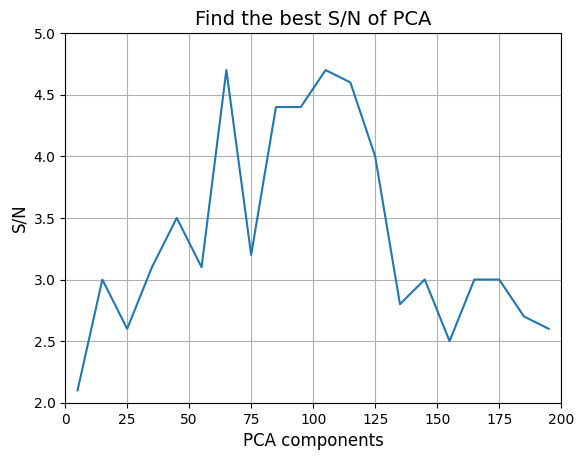

In [22]:
plt.plot(num_components, all_snr_pca)
plt.ylabel("S/N", fontsize=12)
plt.xlabel("PCA components", fontsize=12)
plt.title("Find the best S/N of PCA", fontsize=14)

plt.xlim(0, 200)
plt.ylim(2, 5)
plt.grid()

In [23]:
best_num_pca = num_components[np.argmax(all_snr_pca)]
print("The best number of components is: " + str(best_num_pca))
print("The peak S/N is : " + str(np.max(all_snr_pca)))

The best number of components is: 65
The peak S/N is : 4.7


Text(0.5, 1.01, 'Optimal PCA (65 components)')

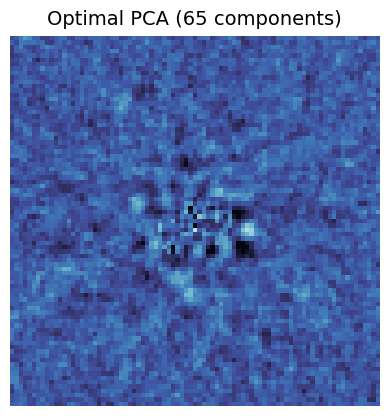

In [24]:
pca_residual_frame = pca_residuals[np.argmax(all_snr_pca)]
median= np.median(pca_residual_frame)
scale = np.max(np.abs(pca_residual_frame))
zoom = 15

plt.imshow(
    pca_residual_frame[zoom:-zoom, zoom:-zoom],
    cmap=color_map,
    vmin=median - scale*0.5, vmax=median + scale*0.8,
    origin="lower")
plt.axis("off")
plt.title("Optimal PCA (65 components)", fontsize=14,y=1.01)

### 3.5 Create a Master Template for the PSF

In [25]:
psf_frames = pipeline.get_data("psf_selected")

In [26]:
psf_template = np.median(psf_frames, axis=0)

(-0.5, 114.5, 114.5, -0.5)

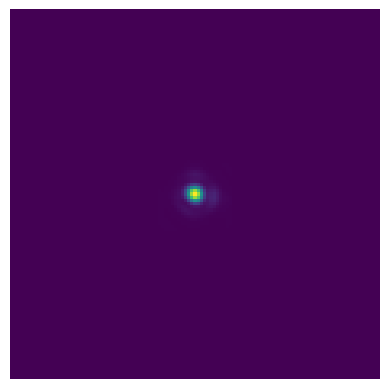

In [27]:
# pad the psf template
padded_psf = np.pad(psf_template, 
                  pad_width=((46, 46), (46, 46)), 
                  mode='constant', 
                  constant_values=0)

plt.imshow(padded_psf)
plt.axis("off")

In [28]:
psf_port = OutputPort("01_psf_padded",
                      pipeline.m_data_storage)
psf_port.set_all(np.expand_dims(padded_psf, axis=0))

### 3.6 Simplex minimization, used as initialization for MCMC

In [29]:
simplex_module = pp.SimplexMinimizationModule(
    name_in='03_simplex', 
    image_in_tag='01_science_prep', 
    psf_in_tag='01_psf_padded', 
    res_out_tag='03_simplex_residual', 
    flux_position_tag='03_simplex_result',
    position=(init_planet_position[0], init_planet_position[1]), 
    magnitude=9.5, 
    psf_scaling=-1/0.0179,  # The data is taken with an ND filter
    merit='hessian', 
    tolerance=0.1, 
    pca_number=int(best_num_pca), 
    residuals='mean', 
    offset=2) 

In [30]:
pipeline.add_module(simplex_module) 
pipeline.run_module('03_simplex')


-------------------------
SimplexMinimizationModule
-------------------------

Module name: 03_simplex
Input ports: 01_science_prep (2761, 115, 115), 01_psf_padded (1, 115, 115)
Input parameters:
   - Number of principal components = [65]
   - Figure of merit = hessian
   - Residuals type = mean
   - Absolute tolerance (pixels/mag) = 0.1
   - Maximum offset = 2
   - Guessed position (x, y) = (68.55, 54.78)
   - Aperture position (x, y) = (69, 55)
   - Aperture radius (pixels) = 3
Image center (y, x) = (57.0, 57.0)
Simplex minimization... 65 PC - chi^2 = 1.52e+01 [DONE]
Best-fit parameters:
   - Position (x, y) = (68.78, 54.75)
   - Separation (mas) = 323.70
   - Position angle (deg) = 259.19
   - Contrast (mag) = 9.98
Output ports: 03_simplex_residual (41, 115, 115), 03_simplex_result (41, 6)


In [31]:
simplex_results = pipeline.get_data('03_simplex_result')

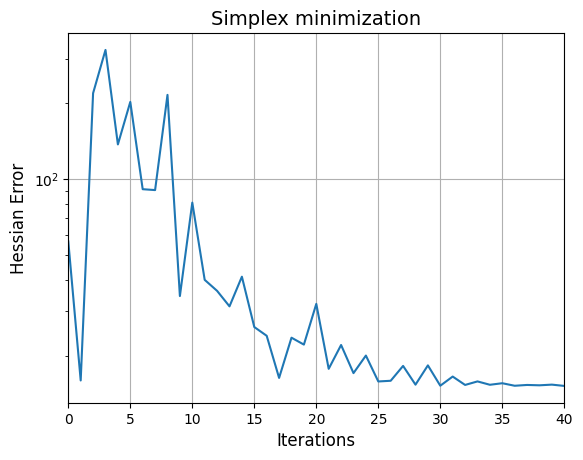

In [32]:
# Simplex Error
plt.plot(simplex_results[:, -1])
plt.yscale("log")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Hessian Error", fontsize=12)
plt.title("Simplex minimization", fontsize=14)
plt.xlim(0, 40)
plt.grid()

In [33]:
best_idx = np.argmin(simplex_results[:, -1])
best_idx

40

In [34]:
simplex_best_result = simplex_results[best_idx, :]
simplex_best_result

array([ 68.77608758,  54.75116433,   0.32370005, 259.18860748,
         9.98117147,  15.16769487])

In [35]:
residual_no_planet = pipeline.get_data('03_simplex_residual')[best_idx]

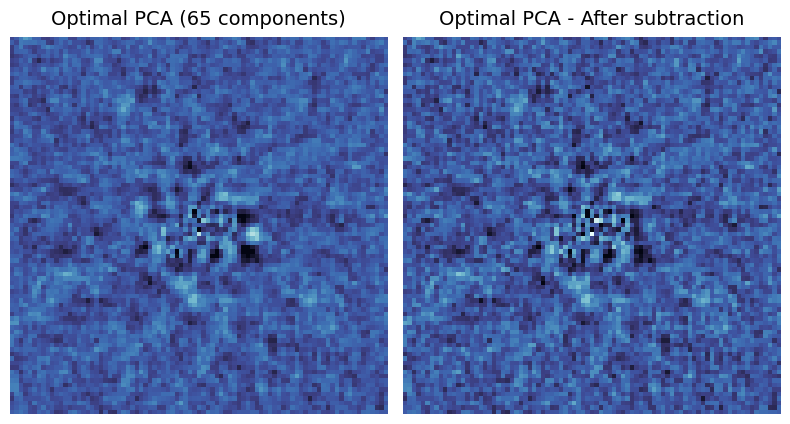

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Plot the original residual
median= np.median(pca_residual_frame)
scale = np.max(np.abs(pca_residual_frame))
zoom = 15

ax1.imshow(
    pca_residual_frame[zoom:-zoom, zoom:-zoom],
    cmap=color_map,
    vmin=median - scale*0.5, vmax=median + scale*0.8,
    origin="lower")

ax1.axis("off")
ax1.set_title("Optimal PCA (65 components)", fontsize=14,y=1.01)

# Plot the residual without the planet
ax2.imshow(
    residual_no_planet[zoom:-zoom, zoom:-zoom],
    cmap=color_map,
    vmin=median - scale*0.5, vmax=median + scale*0.8,
    origin="lower")

ax2.axis("off")
ax2.set_title("Optimal PCA - After subtraction", fontsize=14,y=1.01)

plt.tight_layout()

### 3.7 Run MCMC to get an estimate of the Error

In [54]:
# Bounds for the MCMC 
# Separations +- 100 mas
# Angle +- 10 deg
# Contrast +- 1 mag

dsep, dphi, dcontrast = 0.1, 10, 1.0

mcmc_module = pp.MCMCsamplingModule(
    name_in='04_MCMC_planet', 
    image_in_tag='01_science_prep', 
    psf_in_tag='01_psf_padded', 
    chain_out_tag='04_MCMC_chain', 
    param=tuple(simplex_best_result[2:5]), 
    bounds=((simplex_best_result[2]-dsep, simplex_best_result[2]+dsep),
            (simplex_best_result[3]-dphi, simplex_best_result[3]+dphi),
            (simplex_best_result[4]-dcontrast, simplex_best_result[4]+dcontrast)), 
    nwalkers=100,
    nsteps=500,
    psf_scaling=-1/0.0179, # ND filter
    pca_number=int(best_num_pca), 
    mask=None, 
    extra_rot=0.0, 
    merit='hessian', 
    residuals='mean', 
    resume=True)

In [ ]:
pipeline.add_module(mcmc_module)
pipeline.run_module('04_MCMC_planet')

### 3.8 Plot the result

In [56]:
mcmc_results = pipeline.get_data('04_MCMC_chain')

In [85]:
mcmc_angles = mcmc_results[-50:,:, 1].flatten()
mcmc_separations = mcmc_results[-50:,:, 0].flatten() * 1000
mcmc_contrast = mcmc_results[-50:,:, 2].flatten()

The true north in NACO can be off by about 0.5 deg. Rameau et. al 2013 calibtrated north for our dataset. 
We use their calibration to update the position angles

In [146]:
mcmc_angles = mcmc_angles - 0.38 # the error is negligible

In [147]:
def get_statistic(sample_in):
    median = np.median(sample_in)
    low = np.quantile(sample_in, 0.16)
    high = np.quantile(sample_in, 0.84)
    
    plus = high - median
    minus = low - median
    
    return np.round(median, 2), np.round(plus, 2), np.round(minus, 2)

In [148]:
print(get_statistic(mcmc_angles))
median_angle, plus_angle, minus_angle = get_statistic(mcmc_angles)

(258.81, 0.53, -0.59)


In [149]:
print(get_statistic(mcmc_separations))
median_separations, plus_separations, minus_separations = get_statistic(mcmc_separations)

(323.24, 6.71, -6.44)


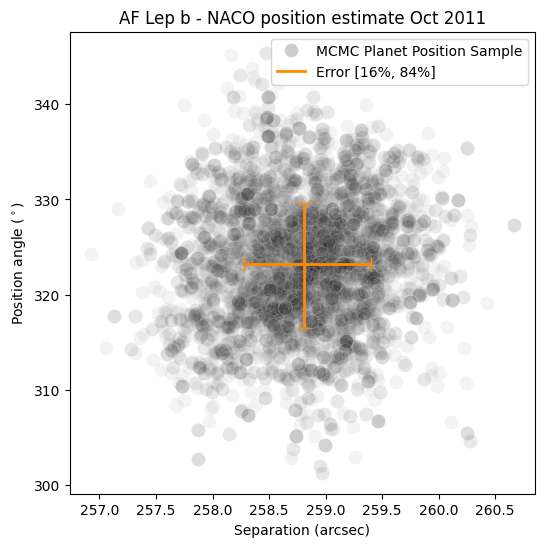

In [163]:
x = mcmc_angles
y = mcmc_separations

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=mcmc_angles,
    y=mcmc_separations, 
    s=100, 
    color=".15", 
    alpha=0.05, 
    label='MCMC planet position sample')

ax.errorbar(
    x=median_angle,
    xerr=np.array([plus_angle, -minus_angle]).reshape(2, 1),
    y=median_separations,
    yerr=np.array([plus_separations, -minus_separations]).reshape(2, 1),
    c='darkorange',
    lw=2,
    capsize=5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='MCMC Planet Position Sample',
                          markerfacecolor='k', markersize=10, alpha=0.2),
                   Line2D([0], [0], color='darkorange', lw=2, label='Error [16%, 84%]')]

ax.legend(handles=legend_elements, loc='best')

ax.ticklabel_format(useOffset=False)
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel(r'Position angle ($^\circ$)')
ax.set_title('AF Lep b - NACO position estimate Oct 2011')
f.savefig('final_plots/x1_AF_Lep_NACO_position_estimate.pdf', bbox_inches='tight')
plt.show()

In [157]:
print(get_statistic(mcmc_contrast))
median_contrast, plus_contrast, minus_contrast = get_statistic(mcmc_contrast)

(10.03, 0.13, -0.12)


In [155]:
host_mag = 4.93
host_error = 0.01

In [160]:
apparent_mag = np.round(median_contrast + host_mag, 2)
apparent_mag

14.96

In [161]:
Abs_mag = 12.81